# 13. 深層強化学習によるCart Pole制御

---
## 目的
Deep Q Learningを用いてCart Pole制御を行う．
ここで，Cart Pole制御とは台車に乗っている棒が倒れないように台車を左右に動かすことである．


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではChainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


### モジュールの追加インストール
Google ColaboratoryにはChainerで深層強化学習を扱うためのモジュール`ChainerRL`がインストールされていないため，下記のプログラムを実行してChainerRLをインストールする．
また，実験結果の表示に必要な追加ライブラリやモジュールもインストールする．

In [1]:
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg > /dev/null
!pip -q install chainerrl
!pip -q install pyglet==1.2.4
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

     |████████████████████████████████| 112kB 2.9MB/s 
     |████████████████████████████████| 972kB 2.9MB/s 


## モジュールのインポート
はじめに必要なモジュールをインポートする．

今回はchainerに加えて，chainerで深層強化学習を扱うためのchainerrlとCart Poleを実行するためのシミュレータであるopenAI Gym（gym）をインポートする．

In [0]:
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym

## OpenAI GymによるCart Poleの環境の定義
 [OpenAI Gym](https://github.com/openai/gym) は，様々な種類の環境を提供しているモジュールです．
 
 今回は古典的な制御問題であるCart Pole（倒立振子）を実行します．
 まず，gym.make関数で実行したい環境を指定します．
 その後，reset関数を実行することで，環境を初期化します．
 
cart pole環境では，倒立振子の現在の状態を把握するために，振子の角度や台車の速度などの4次元の情報が与えられており，`observation_space`という変数で確認することができます．
また，`action_space`という変数で，エージェントが取ることのできる行動の数を確認することができます．
cart poleの場合は，台車を左右どちらかに移動させるという行動を取るため，行動の数は2となっています．




In [3]:
# 環境の指定
env = gym.make('CartPole-v0')

# 環境の初期化
obs = env.reset()
#env.render()
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('initial observation:', obs)

# 行動の決定と決定した行動の入力
action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

observation space: Box(4,)
action space: Discrete(2)
initial observation: [ 0.04747941  0.03016419 -0.01831596  0.04715099]
next observation: [ 0.0480827  -0.1646904  -0.01737294  0.33399926]
reward: 1.0
done: False
info: {}


## ネットワークモデルの定義

ネットワークモデルを定義します．
ここでは，環境からの情報を入力し，行動に対するQ値を出力するようなネットワークを定義するために，全結合層3層から構成されるネットワークとします．

入力データのサイズをobs_size，出力する行動の数をn_actions，中間層のサイズをn_hidden_channelsとし，ネットワークの作成時に変更できるようにしておきます．

\__call\__関数では，これまでに学習したニューラルネットワークネットワークの場合と同様の手順でデータの計算を行いますが，最後の出力部分にDiscreteActionValueというchainerRLの関数を用いています．Q値を出力するための関数です．



In [0]:
class QFunction(chainer.Chain):
  def __init__(self, obs_size, n_actions, n_hidden_channels=50):
    super().__init__()
    with self.init_scope():
      self.l0 = L.Linear(obs_size, n_hidden_channels)
      self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)
      self.l2 = L.Linear(n_hidden_channels, n_actions)

  def __call__(self, x, test=False):
    h = F.tanh(self.l0(x))
    h = F.tanh(self.l1(h))
    return chainerrl.action_value.DiscreteActionValue(self.l2(h))

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．

まず，環境から，入力データのサイズと行動の数を変数に格納し，ネットワークを作成します．
ここでは，GPUで学習を行うために，modelをGPUに送るto_gpu関数を利用しています．

また，最適化手法としてAdamを使用し，setup関数にネットワークモデルを与えます．

In [5]:
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)
q_func.to_gpu(0)

optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

 ## Deep Q-Networkの作成
 上で作成したQ関数（ネットワーク）とその最適化関数は，DQNのエージェントによって使用されます．
 DQNのエージェントを作成するには，より多くのパラメータと設定を指定する必要があります．

In [0]:
# 割引率の指定
gamma = 0.95

# epsilon-greedy法の指定
explorer = chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample)

# Experience Replayの指定
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)


# CartPole-v0から獲得される環境の情報はnumpy.float64だが，
# Chainerに入力するデータの型はnumpy.float32である．
# そのため，環境から得られた情報を変換するためのコンバータを定義している．
phi = lambda x: x.astype(np.float32, copy=False)

# 上記の情報とネットワークを用いて，DQNのエージェントを作成する．
agent = chainerrl.agents.DQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

## 学習

学習を行います．
今回は学習するエピソード数を100，1エピソードの最大の行動数を200とします．

In [7]:
n_episodes = 100
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)

episode: 10 R: 20.0 statistics: [('average_q', 0.00019553182782589505), ('average_loss', 0), ('n_updates', 0)]
episode: 20 R: 19.0 statistics: [('average_q', -0.0009900333460268048), ('average_loss', 0), ('n_updates', 0)]
episode: 30 R: 11.0 statistics: [('average_q', 0.009962170467373315), ('average_loss', 0.15626564678634094), ('n_updates', 56)]
episode: 40 R: 9.0 statistics: [('average_q', 0.09985298083397566), ('average_loss', 0.16519186215228157), ('n_updates', 164)]
episode: 50 R: 25.0 statistics: [('average_q', 0.4010299344062983), ('average_loss', 0.10691164446315925), ('n_updates', 318)]
episode: 60 R: 37.0 statistics: [('average_q', 1.201536913145278), ('average_loss', 0.12576654242730104), ('n_updates', 561)]
episode: 70 R: 37.0 statistics: [('average_q', 3.411811619650665), ('average_loss', 0.20140916758890823), ('n_updates', 1058)]
episode: 80 R: 160.0 statistics: [('average_q', 6.418203012870813), ('average_loss', 0.2570553441643746), ('n_updates', 1734)]
episode: 90 R: 2

## テスト（結果の確認）

学習したネットワーク（エージェント）を確認してみます．

### Cart Pole表示の環境設定
通常のColaboratoryの設定では，Cart Poleの実行結果を表示することはできません．
そのため，下記のコードを実行して，ノートブックないにCartPoleの制御結果を表示できるようにします．

In [8]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


 ここでは，3回のCartPole制御を実行しています．
全ての動画フレームを`frames`というリストへ格納することで，その結果を保存しています．

その後，maptlotlibを用いて，保存した動画フレームをアニメーションとして作成し，表示しています．


test episode: 0 R: 200.0
test episode: 1 R: 200.0
test episode: 2 R: 200.0


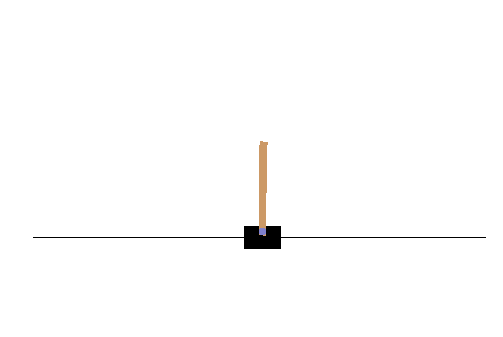

In [9]:
frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()
env.render()

# 実行結果の表示
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## 課題
1. 各エピソードのTotal rewordの推移を確認せよ．
2. DQNの中間層のユニット数を変化させて，Cart poleの制御結果の変化を確認せよ．